# Results from physics-informed training 
    with 2D triangle wake
- Plot sensors, interpolated, predicted.
- Plot sensor loss, diveregence, momentum residue (x and y)
- Plot original data compared with predicted, show relative MSE.
- Use probe, plot frequency at locations.

In [1]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".30"
from pathlib import Path
import numpy as np
import h5py
import jax
import jax.numpy as jnp
import yaml

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import griddata

import flowrec.training_and_states as state_utils
from utils import simulation2d
import flowrec.data as data_utils
from flowrec import losses
import flowrec.physics_and_derivatives as derivatives
from utils.py_helper import slice_from_tuple

In [2]:
results_dir = Path('../local_results/sweep_weights_0582grfn:v1')
print('Does directory exist?',results_dir.exists())
! ls $results_dir

Does directory exist? True
config.yml  results.h5	state.npy  state.pkl


# Load configurations and results

In [3]:
with open(Path(results_dir,'config.yml'),'r') as f:
    cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
cfg.data_config.update({'data_dir':'.'+cfg.data_config.data_dir})

with h5py.File(Path(results_dir,'results.h5'),'r') as hf:
    loss_train = np.array(hf.get("loss_train"))
    loss_val = np.array(hf.get("loss_val"))
    loss_div = np.array(hf.get("loss_div"))
    loss_momentum = np.array(hf.get("loss_momentum"))
    loss_sensors = np.array(hf.get("loss_sensors"))

## Load data

In [4]:
x_base = 132
triangle_base_coords = [49,80]
(ux,uy,pp) = simulation2d.read_data(cfg.data_config.data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
# remove parts where uz is not zero
s = slice_from_tuple(cfg.data_config.slice_to_keep)
x = x[s]

## partition data
[x_train,x_val,x_test], _ = data_utils.data_partition(x,
    1,
    cfg.data_config.train_test_split,
    REMOVE_MEAN=cfg.data_config.remove_mean,
    randseed=cfg.data_config.randseed,
    SHUFFLE=cfg.data_config.shuffle
) # Do not shuffle, do not remove mean for training with physics informed loss


[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))


## normalise
if cfg.data_config.normalise:
    [ux_train_normal,uy_train_normal,pp_train_normal], train_minmax = data_utils.normalise(ux_train,uy_train,pp_train)
    [ux_val_normal,uy_val_normal,pp_val_normal], val_minmax = data_utils.normalise(ux_val,uy_val,pp_val)
    [ux_test_normal,uy_test_normal,pp_test_normal], test_minmax = data_utils.normalise(ux_test,uy_test,pp_test)
    ## take input
    pb_train = simulation2d.take_measurement_base(pp_train_normal,ly=triangle_base_coords,centrex=0)
    pb_val = simulation2d.take_measurement_base(pp_val_normal,ly=triangle_base_coords,centrex=0)
    pb_test = simulation2d.take_measurement_base(pp_test_normal,ly=triangle_base_coords,centrex=0)
else:
    ## take input
    pb_train = simulation2d.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
    pb_val = simulation2d.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
    pb_test = simulation2d.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)


# information about the grid
datainfo = data_utils.DataMetadata(
    re = cfg.data_config.re,
    discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()

pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
pb_val = np.reshape(pb_val,(cfg.data_config.train_test_split[1],-1))
pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)



In [5]:
## measure
take_observation, insert_observation = cfg.case.observe(cfg.data_config)
observed_train = take_observation(u_train)
observed_val = take_observation(u_val)
observed_test = take_observation(u_test)

In [6]:
t_plt = 20

## Visualise input data
Sensors and interpolated flow field.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


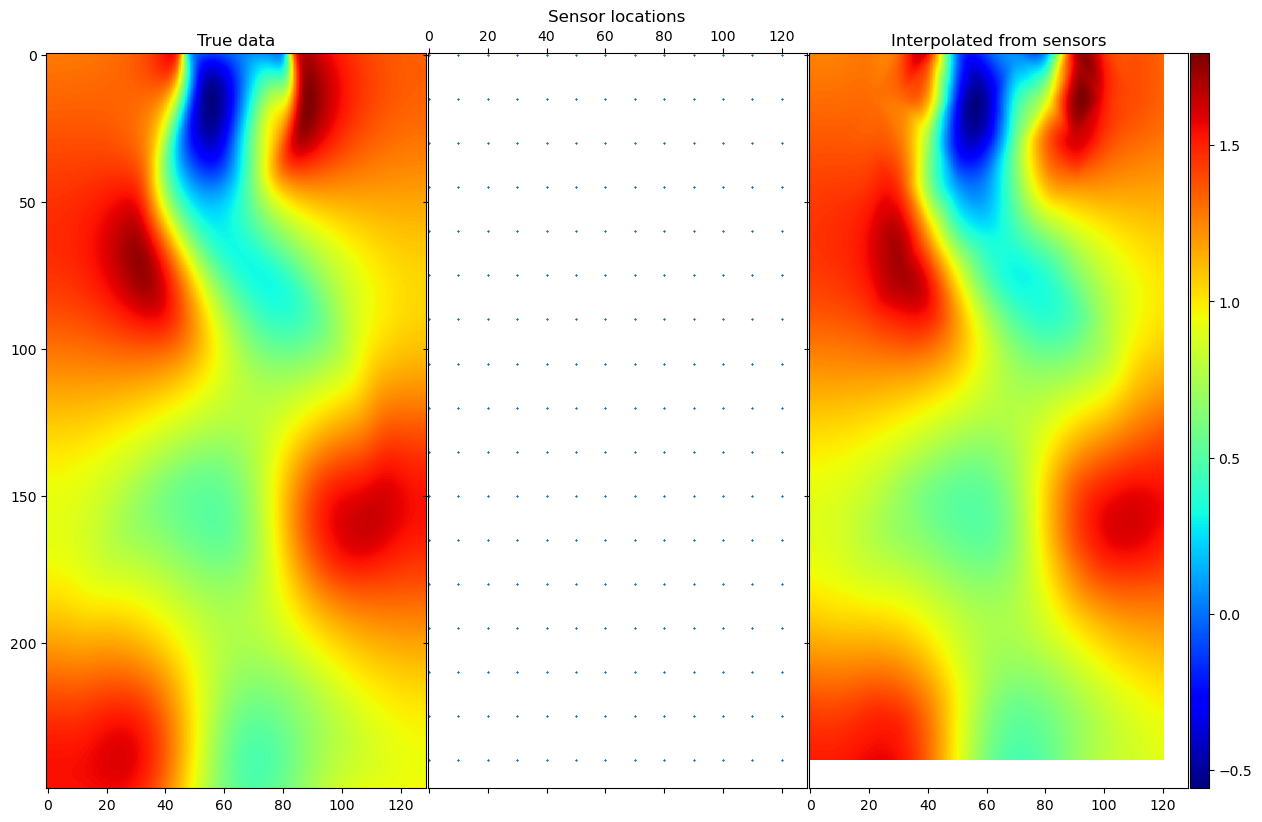

In [7]:
observed_plot = np.empty_like(u_train)
observed_plot.fill(np.nan)
observed_plot = insert_observation(jnp.asarray(observed_plot),jnp.asarray(observed_train))

# interpolate
if cfg.case._case_observe == 'grid':
    slice_grid = slice_from_tuple(cfg.data_config.slice_grid_sensors)
grid_x,grid_y = np.mgrid[0:ux_train.shape[1], 0:ux_train.shape[2]]
sensors_loc_x = grid_x[slice_grid]
sensors_loc_y = grid_y[slice_grid]
sensors_loc = np.stack((sensors_loc_x.flatten(),sensors_loc_y.flatten()),axis=-1)
data_interp = griddata(sensors_loc, observed_train[t_plt,...,0].flatten(), (grid_x,grid_y), method='cubic')


fig = plt.figure(figsize=(15,30))
axes = ImageGrid(fig,111,(1,3),share_all=True,cbar_mode='single')
axes.axes_all[0].imshow(u_train[t_plt,...,0],'jet')
axes.axes_all[0].set_title('True data')
axes.axes_all[1].spy(observed_plot[t_plt,...,0],marker='x',markersize=1)
axes.axes_all[1].set_title('Sensor locations')
im = axes.axes_all[2].imshow(data_interp,'jet')
axes.axes_all[2].set_title('Interpolated from sensors')
axes.cbar_axes[0].colorbar(im)
plt.show()

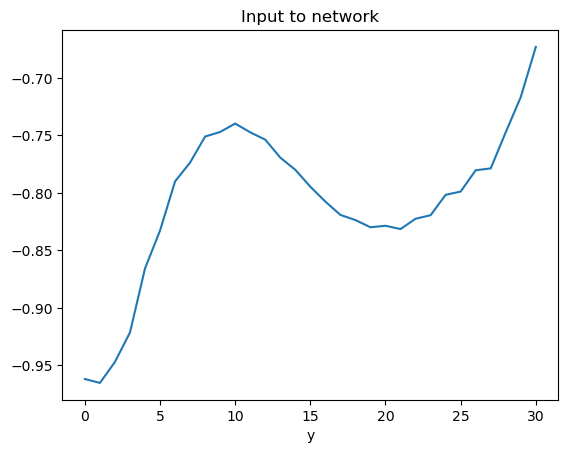

In [8]:
plt.figure()
plt.plot(pb_train[t_plt,:])
plt.title('Input to network')
plt.xlabel('y')
plt.show()

# Loss
Plot different losses:
- Sensors
- Divergence
- Momentum residue
- Total physics loss
- Total loss

Also plot relative mse of the entire predicted flow field and compare with interpolated.

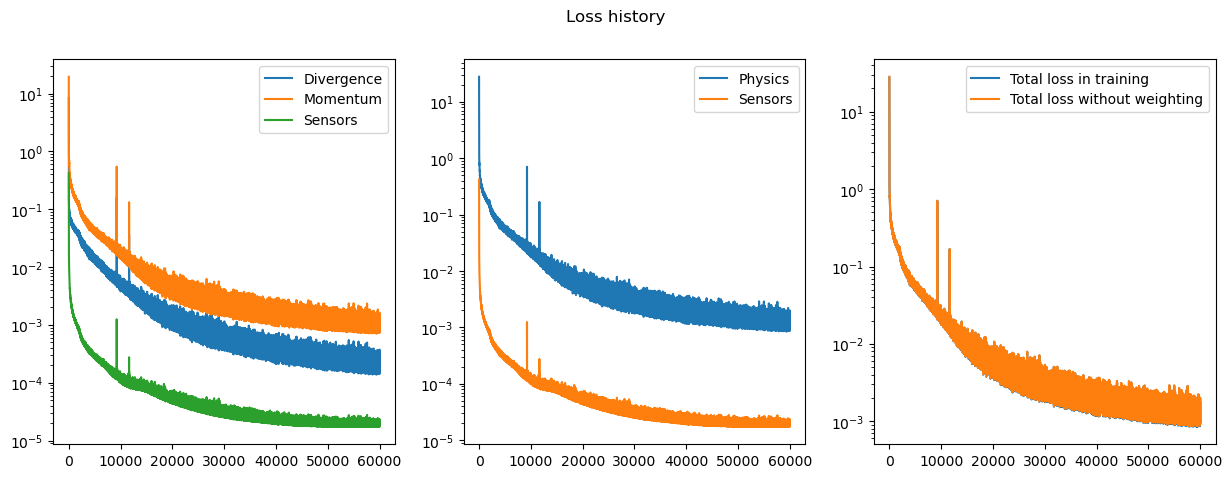

In [9]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Loss history')
axes[0].plot(loss_div,label='Divergence')
axes[0].plot(loss_momentum,label='Momentum')
axes[0].plot(loss_sensors,label='Sensors')
axes[0].legend()
axes[0].set_yscale('log')
axes[1].plot(loss_div+loss_momentum,label='Physics')
axes[1].plot(loss_sensors,label='Sensors')
axes[1].legend()
axes[1].set_yscale('log')
axes[2].plot(loss_train,label='Total loss in training')
axes[2].plot(loss_div+loss_momentum+loss_sensors,label='Total loss without weighting')
axes[2].legend()
axes[2].set_yscale('log')
plt.show()

## Load model

In [10]:
state = state_utils.restore_trainingstate(results_dir,'state')
jax.tree_util.tree_map(lambda x: print(x.shape),state.params)

(32,)
(5, 5, 3, 32)
(16,)
(5, 5, 32, 16)
(3,)
(5, 5, 16, 3)
(96750,)
(31, 96750)


{'mlp_with_cnn/~/convolve_0': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_1': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_2': {'b': None, 'w': None},
 'mlp_with_cnn/~/mlp/~/linear_0': {'b': None, 'w': None}}

In [11]:
_, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
mdl = make_model(cfg.model_config)

In [14]:
jax.devices()

[CpuDevice(id=0)]

In [13]:
from flowrec.models.cnn import Model

mdl = Model(mlp_layers=cfg.model_config.mlp_layers,output_shape=cfg.model_config.output_shape,cnn_channels=cfg.model_config.cnn_channels,cnn_filters=cfg.model_config.cnn_filters) # no dropout rate because it is used only for prediction
rng = jax.random.PRNGKey(10)

pred_train = mdl.apply(state.params,rng,pb_train)
pred_train = data_utils.unnormalise(pred_train,train_minmax)
pred_test = mdl.apply(state.params,rng,pb_test)
pred_test = data_utils.unnormalise(pred_test,test_minmax)


MemoryError: std::bad_alloc

Calculate physics loss

In [ ]:
l_d_test = derivatives.div_field(pred_test[...,0],pred_test[...,1],data_info)
l_m_test = derivatives.momentum_residue_field(pred_test[...,0],pred_test[...,1],pred_test[...,2],data_info)


l_d_true = derivatives.div_field(u_test[...,0],u_test[...,1],data_info)
l_m_true = derivatives.momentum_residue_field(u_test[...,0],u_test[...,1],u_test[...,2],data_info)

fig = plt.figure(figsize=(12,6))
grid = ImageGrid(fig,111,(1,3),cbar_mode='each',axes_pad=0.3,cbar_pad=0.05)
for ax, cax, plt_data in zip(grid.axes_all, grid.cbar_axes, [l_d_true, l_m_true[0,...], l_m_true[1,...]]):
    im = ax.imshow(np.mean(plt_data,axis=0),'jet')
    cax.colorbar(im)
fig.suptitle('Time-averaged divergence, momentum residue x and y for true data.')
plt.show()

## Plot comparison between prediction and True

In [ ]:
fig = plt.figure(figsize=(12,15))
set_name = ['$u_x$','$u_y$','$p$']

# predicted
grid = ImageGrid(fig,131,(3,1),cbar_mode='each',axes_pad=(0.02,0.3))
mse_plane = np.einsum('t x y i -> x y i', (pred_test-u_test)**2)/train_test_split[2]
for i, (ax,cax) in enumerate(zip(grid[:3],grid.cbar_axes[:3])):
    im = ax.imshow(pred_test[t_plt,:,:,i],'jet')
    ax.set_title(f'Predicted {set_name[i]}')
    cax.colorbar(im)
    ax.grid()

# true
grid = ImageGrid(fig,132,(3,1),cbar_mode='each',axes_pad=(0.02,0.3))
mse_plane = np.einsum('t x y i -> x y i', (pred_test-u_test)**2)/train_test_split[2]
for i, (ax,cax) in enumerate(zip(grid[:3],grid.cbar_axes[:3])):
    im = ax.imshow(u_test[t_plt,:,:,i],'jet')
    ax.set_title(f'True {set_name[i]}')
    cax.colorbar(im)
    ax.grid()

# loss
grid = ImageGrid(fig,133,(3,1),cbar_mode='each',axes_pad=(0.02,0.3))
mse_plane = np.einsum('t x y i -> x y i', (pred_test-u_test)**2)/train_test_split[2]
for i, (ax,cax) in enumerate(zip(grid[:3],grid.cbar_axes[:3])):
    im = ax.imshow(mse_plane[:,:,i],'jet')
    ax.set_title(f'MSE, relative error = {losses.relative_error(pred_test[...,i],u_test[...,i]):.7f}')
    cax.colorbar(im)
    ax.grid()

fig.suptitle(f'Columns showing instantaneous prediction, true data at t={t_plt} and time averaged MSE.')
plt.show()

Physics loss comparison

In [ ]:
compare_interp = []

for i in range(3):
    for j in range(train_test_split[2]):
        compare_interp.append(
            griddata(sensors_loc, observed_test[j,...,i].flatten(), (grid_x,grid_y), method='cubic')
        )
compare_interp = np.array(compare_interp)
compare_interp = np.stack((compare_interp[:train_test_split[2],...],compare_interp[train_test_split[2]:2*train_test_split[2],...],compare_interp[2*train_test_split[2]:3*train_test_split[2],...]),axis=-1)
nb_elements = np.count_nonzero(~np.isnan(compare_interp[1,...,0]))
compare_interp.shape

In [ ]:
interp_physics = derivatives.div_field(compare_interp[...,0],compare_interp[...,1],datainfo=data_info) + np.sum(derivatives.momentum_residue_field(compare_interp[...,0],compare_interp[...,1],compare_interp[...,2],datainfo=data_info),axis=0)
# interp_physics = np.nan_to_num(interp_physics)
interp_physics.shape

In [ ]:
which_value = 2
t_compare = 22
fig = plt.figure(figsize=(12,15))
fig.suptitle(f'Instantaneous comparison at t={t_compare}')
grid = ImageGrid(fig,(0,0,1,0.95),(3,3),cbar_mode='each',axes_pad=(0.5,0.5),cbar_pad=0.005)
ax = grid.axes_all
cax = grid.cbar_axes

ax[0].set_title('True')
im = ax[0].imshow(u_test[t_compare,...,which_value],'jet')
cax[0].colorbar(im)
ax[1].set_title('Predicted')
im = ax[1].imshow(pred_test[t_compare,...,which_value],'jet')
cax[1].colorbar(im)
ax[2].set_title('Interpolated (cubic)')
im = ax[2].imshow(compare_interp[t_compare,...,which_value],'jet')
cax[2].colorbar(im)

ax[3].axis('off')
cax[3].axis('off')
ax[4].set_title(f'inst. MSE = {losses.mse(pred_test[t_compare,...,which_value],u_test[t_compare,...,which_value]):.7f}')
im = ax[4].imshow((pred_test[t_compare,...,which_value]-u_test[t_compare,...,which_value])**2,'jet')
cax[4].colorbar(im)
mse_interp = np.sum(np.nan_to_num(compare_interp[t_compare,...,which_value] - u_test[t_compare,...,which_value])**2)/nb_elements
ax[5].set_title(f'inst. MSE = {mse_interp:.7f}')
im = ax[5].imshow((compare_interp[t_compare,...,which_value]-u_test[t_compare,...,which_value])**2,'jet')
cax[5].colorbar(im)

ax[6].set_title(f'inst. residue\n= {np.mean((l_d_true+l_m_true[0,...]+l_m_true[1,...])[t_compare,...]):.7f}')
# im = ax[6].imshow(np.abs((l_mx_true)[t_compare,...]),'jet')
im = ax[6].imshow(np.abs((l_d_true+l_m_true[0,...]+l_m_true[1,...])[t_compare,...]),'jet')
cax[6].colorbar(im)
ax[7].set_title(f'inst. residue\n= {np.mean((l_d_test+l_m_test[0,...]+l_m_test[1,...])[t_compare,...]):.7f}')
im = ax[7].imshow(np.abs((l_d_test+l_m_test[0,...]+l_m_test[1,...])[t_compare,...]),'jet')
cax[7].colorbar(im)
ax[8].set_title(f'inst. residue\n= {np.sum(np.nan_to_num(interp_physics[t_compare,:,:])/nb_elements):.7f}')
im = ax[8].imshow(np.abs(interp_physics[t_compare,...]),'jet')
cax[8].colorbar(im)


for ax in grid:
    ax.grid()

plt.show()

In [ ]:
plt.figure()
plt.title('Unweighted physics losses')
temp = np.mean(l_d_true,axis=[1,2])
plt.plot(temp,label='div')
temp = np.mean(np.sum(l_m_true,axis=0),axis=[1,2])
plt.plot(temp,label='momentum')
plt.legend()
plt.xlabel('t')
plt.show()

## Statistics

In [ ]:
# probe location
probe_loc = [110,60]

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)
ax.spy(observed_plot[t_plt,...,0],marker='x',markersize=2,c='k')
ax.imshow(ux_test[0,:,:],'jet',alpha=0.5)
ax.scatter(probe_loc[1],probe_loc[0],zorder=20,c='r')
ax.grid()
plt.show()

In [ ]:
# Frequencies in true data
probe_ux_true = ux_test[:,probe_loc[0],probe_loc[1]]
probe_uy_true = uy_test[:,probe_loc[0],probe_loc[1]]
probe_p_true = pp_test[:,probe_loc[0],probe_loc[1]]

freq = np.fft.fftfreq(len(probe_ux_true),d=0.0002*1250)
f_ux_true = np.fft.fft(probe_ux_true-np.mean(probe_ux_true))/len(probe_ux_true)
f_uy_true = np.fft.fft(probe_uy_true-np.mean(probe_uy_true))/len(probe_uy_true)
f_p_true = np.fft.fft(probe_p_true-np.mean(probe_p_true))/len(probe_p_true)

In [ ]:
plt.figure()
plt.plot(probe_ux_true)

In [ ]:
# frequencies
probe_ux_pred = pred_test[:,probe_loc[0],probe_loc[1],0]
probe_uy_pred = pred_test[:,probe_loc[0],probe_loc[1],1]
probe_p_pred = pred_test[:,probe_loc[0],probe_loc[1],2]

# freq = np.fft.fftfreq(len(probe_ux_pred),d=0.0002*1250)
f_ux_pred = np.fft.fft(probe_ux_pred-np.mean(probe_ux_pred))/len(probe_ux_pred)
f_uy_pred = np.fft.fft(probe_uy_pred-np.mean(probe_uy_pred))/len(probe_uy_pred)
f_p_pred = np.fft.fft(probe_p_pred-np.mean(probe_p_pred))/len(probe_p_pred)

# frequencies
probe_ux_interp = compare_interp[:,probe_loc[0],probe_loc[1],0]
probe_uy_interp = compare_interp[:,probe_loc[0],probe_loc[1],1]
probe_p_interp = compare_interp[:,probe_loc[0],probe_loc[1],2]

# freq = np.fft.fftfreq(len(probe_ux_interp),d=0.0002*1250)
f_ux_interp = np.fft.fft(probe_ux_interp-np.mean(probe_ux_interp))/len(probe_ux_interp)
f_uy_interp = np.fft.fft(probe_uy_interp-np.mean(probe_uy_interp))/len(probe_uy_interp)
f_p_interp = np.fft.fft(probe_p_interp-np.mean(probe_p_interp))/len(probe_p_interp)


In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].set(title='Frequency spectrum of prediction',xlabel='f',xlim=[0,2])
ax[0].plot(freq[:int(len(freq)/2)], np.abs(f_ux_pred)[:int(len(freq)/2)],label='ux')
ax[0].plot(freq[:int(len(freq)/2)], np.abs(f_uy_pred)[:int(len(freq)/2)],label='uy')
ax[0].plot(freq[:int(len(freq)/2)], np.abs(f_p_pred)[:int(len(freq)/2)],label='p')
ax[0].legend()
ax[0].minorticks_on()
ax[0].grid(True,which='both',axis='x')

ax[1].set(title='Frequency spectrum of interpolated data',xlabel='f',xlim=[0,2])
ax[1].plot(freq[:int(len(freq)/2)], np.abs(f_ux_interp)[:int(len(freq)/2)],label='ux')
ax[1].plot(freq[:int(len(freq)/2)], np.abs(f_uy_interp)[:int(len(freq)/2)],label='uy')
ax[1].plot(freq[:int(len(freq)/2)], np.abs(f_p_interp)[:int(len(freq)/2)],label='p')
ax[1].legend()
ax[1].minorticks_on()
ax[1].grid(True,which='both',axis='x')

ax[2].set(title='Frequency spectrum of true data',xlabel='f',xlim=[0,2])
ax[2].plot(freq[:int(len(freq)/2)], np.abs(f_ux_true)[:int(len(freq)/2)],label='ux')
ax[2].plot(freq[:int(len(freq)/2)], np.abs(f_uy_true)[:int(len(freq)/2)],label='uy')
ax[2].plot(freq[:int(len(freq)/2)], np.abs(f_p_true)[:int(len(freq)/2)],label='p')
ax[2].legend()
ax[2].minorticks_on()
ax[2].grid(True,which='both',axis='x')

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set(title='Frequency spectrum', xlabel='f', xlim=[0,2])
ax.plot(freq[:int(len(freq)/2)], np.abs(f_ux_pred)[:int(len(freq)/2)],label='ux_pred',c='g',linestyle='-')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_uy_pred)[:int(len(freq)/2)],label='uy_pred',c='k',linestyle='-')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_p_pred)[:int(len(freq)/2)],label='p_pred',c='r',linestyle='-')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_ux_interp)[:int(len(freq)/2)],label='ux_interp',c='g',linestyle='--')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_uy_interp)[:int(len(freq)/2)],label='uy_interp',c='k',linestyle='--')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_p_interp)[:int(len(freq)/2)],label='p_interp',c='r',linestyle='--')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_ux_true)[:int(len(freq)/2)],label='ux',c='g',linestyle='',marker='x')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_uy_true)[:int(len(freq)/2)],label='uy',c='k',linestyle='',marker='x')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_p_true)[:int(len(freq)/2)],label='p',c='r',linestyle='',marker='x')
ax.minorticks_on()
ax.legend()
ax.grid(True,which='both',axis='x')

plt.show()

Compare mean squared error

In [ ]:
print('Overall MSE for prediction in testing: ', losses.mse(pred_test,u_test))
mse_interp = np.sum(np.nan_to_num(compare_interp - u_test)**2)/nb_elements
print('Overall MSE for interpolation in testing: ', mse_interp)

In [ ]:
"🤯 END 🤯"